In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import griddata
import warnings

# warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
data = np.loadtxt('tensor_data/Hill_Re2800_ASCII_Breuer.dat', skiprows=16)

In [3]:
N, M = data.shape

In [4]:
# read in DNS data + preprocessing
RS_DNS = torch.tensor(np.array([data[:,6], data[:,9], np.full(N,0),
                                data[:,9], data[:,7], np.full(N,0),
                                np.full(N,0), np.full(N,0), data[:,8]]).T.reshape(-1,3,3))
cellCenters_DNS = torch.tensor([data[:,0],data[:,1]]).T
k0_DNS = torch.from_numpy(RS_DNS.numpy().trace(axis1 = 1, axis2 = 2))

# expand k
k_DNS = k0_DNS.unsqueeze(0).unsqueeze(0).expand(3,3,k0_DNS.size()[0])
k_DNS = k_DNS.permute(2, 0, 1)

# compute anisotropy tensor b
b = RS_DNS * (1/(2*k_DNS)) - 1/3 * torch.ones(k_DNS.size())

In [5]:
# read in RANS data + preprocessing
path = '/home/leonriccius/OpenFOAM_build/OpenFOAM-v2006/custom_cases/periodic_hills_RANS/refined_mesh/5600_kEpsilon/1500/'

# RS_RANS = torch.load(path + 'RS-torch.th')
R = torch.load(path + 'R-torch.th')
S = torch.load(path + 'S-torch.th')
k0 = torch.load(path + 'k-torch.th')
epsilon0 = torch.load(path + 'epsilon-torch.th')
cellCenters_RANS = torch.tensor(torch.load(path + 'cellCenters-torch.th')[:,0:2])

# expand k
k = k0.unsqueeze(0).unsqueeze(0).expand(3,3,k0.size()[0])
k = k.permute(2, 0, 1)

# expand epsilon
epsilon = epsilon0.unsqueeze(0).unsqueeze(0).expand(3,3,epsilon0.size()[0])
epsilon = epsilon.permute(2, 0, 1)

# normalize S and R
r_hat = k/epsilon*R
s_hat = k/epsilon*S

In [6]:
def bounding_box(x_lim, y_lim, cellCenters):
    """function for creating a mask to select points within a bounding box"""
    mask_x_min = np.where(cellCenters[:,0] > x_lim[0])
    mask_x_max = np.where(cellCenters[mask_x_min,0].squeeze() < x_lim[1])
    cellCenters_x = cellCenters[mask_x_min][mask_x_max]
    
    mask_y_min = np.where(cellCenters_x[:,1] > y_lim[0])
    mask_y_max = np.where(cellCenters_x[mask_y_min,1].squeeze() < y_lim[1])
    return (mask_x_min, mask_x_max, mask_y_min, mask_y_max)

In [7]:
def select_from_mask(mask_list, array):
    """function that selects the datapoints when given a list of masks
    list must contain 4 masks created from bounding_box"""
    return array[mask_list[0]][mask_list[1]][mask_list[2]][mask_list[3]]

In [8]:
# creating mask for data selection from RANS field
mask_list = bounding_box([2.75,4.25],[0.75,2.25], cellCenters_RANS)

In [9]:
# selecting RANS data in bounding box
cellCenters_RANS_box = select_from_mask(mask_list, cellCenters_RANS)
r_hat_box = select_from_mask(mask_list, r_hat)
s_hat_box = select_from_mask(mask_list, s_hat)

In [10]:
# creating mask for data selection from DNS field
mask_list_DNS = bounding_box([2.75, 4.25], [0.75, 2.25], cellCenters_DNS)

# selecting DNS data in bounding box
cellCenters_DNS_box = select_from_mask(mask_list_DNS, cellCenters_DNS)
RS_DNS_box = select_from_mask(mask_list_DNS, RS_DNS)
b_box = select_from_mask(mask_list_DNS, b)
cellCenters_DNS_box.shape

torch.Size([2184, 2])

In [11]:
# interpolating on cartesian grid
grid_x, grid_y = np.mgrid[3.:4.:100j, 1.:2.:100j]
grid = [grid_x, grid_y]

# interpolating DNS data (b)
b_interp = torch.tensor(griddata(cellCenters_DNS_box, b_box, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)

# interpolating RANS data (r_hat, s_hat)
r_hat_interp = torch.tensor(griddata(cellCenters_RANS_box, r_hat_box, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)
s_hat_interp = torch.tensor(griddata(cellCenters_RANS_box, s_hat_box, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)

# reshaping grid
grid_interp = torch.tensor([grid_x.flatten(), grid_y.flatten()]).T

# store all data needed for the NN
torch.save(r_hat_interp, 'tensor_data/r_hat-torch.th')
torch.save(s_hat_interp, 'tensor_data/s_hat-torch.th')
torch.save(b_interp, 'tensor_data/b_DNS-torch.th')
torch.save(grid_interp, 'tensor_data/grid-torch.th')

In [12]:
""" first try, interpolation does not work. no idea why it does not work. now using griddata.
this was also very inefficient as interp2d interpolated to a grid of all x- and y-combination and then only diagonal entries can be used
"""
def interpolate_tensor_to_grid(grid_old, grid_new, tensor, tensor_type='symmetric'):
    """function to interpolate data from one geometry to another"""
    tensor_interp = torch.zeros(grid_new.shape[0],3,3)
    # three cases for symmetric, antimetric and all remaining types
    if tensor_type=='symmetric':
        for i in range(3):
            for j in range(3):
                if i > j: # loop over off diagonal
                    f_interp = interpolate.interp2d(grid_old[:,0].flatten(),
                                                    grid_old[:,1].flatten(),
                                                    tensor[:,i,j].flatten(),
                                                    kind='linear')
                    tmp1 = f_interp(grid_new[:,0], grid_new[:,1])
                    tmp2 = tmp1.diagonal()
                    tensor_interp[:,i,j] = torch.tensor(tmp2)
                    tensor_interp[:,j,i] = torch.tensor(tmp2)
                elif i == j:  # loop over diagonal
                    f_interp = interpolate.interp2d(grid_old[:,0].flatten(),
                                                    grid_old[:,1].flatten(),
                                                    tensor[:,i,j].flatten(),
                                                    kind='linear')
                    tmp = f_interp(grid_new[:,0], grid_new[:,1]).diagonal()
                    tensor_interp[:,i,j] = torch.tensor(tmp)
    elif tensor_type=='antimetric':
        for i in range(3):
            for j in range(3):
                if i > j: # loop over off diagonal, no loop over diagonal needed as they are 0
                    f_interp = interpolate.interp2d(grid_old[:,0].flatten(),
                                                    grid_old[:,1].flatten(),
                                                    tensor[:,i,j].flatten(),
                                                    kind='linear')
                    tmp = f_interp(grid_new[:,0], grid_new[:,1]).diagonal()
                    tensor_interp[:,i,j] = torch.tensor(tmp)
                    tensor_interp[:,j,i] = -torch.tensor(tmp)
    else:
        for i in range(3):  # loop over all elements
            for j in range(3):
                f_interp = interpolate.interp2d(grid_old[:,0].flatten(),
                                                grid_old[:,1].flatten(),
                                                tensor[:,i,j].flatten(),
                                                kind='linear')
                tmp = f_interp(grid_new[:,0], grid_new[:,1]).diagonal()
                tensor_interp[:,i,j] = torch.tensor(tmp)
    return tensor_interp

In [13]:
b_interp2d = interpolate_tensor_to_grid(cellCenters_DNS_box, cellCenters_RANS_box, b_box)

/home/leonriccius/.local/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=39,62 m=2184 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
<ipython-input-12-00f4caa3ec1e>:26: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  tensor_interp[:,i,j] = torch.tensor(tmp)
/home/leonriccius/.local/lib/python3.8/site-packages/scipy/interpolate/_fitpac

In [14]:
fine_grid_x, fine_grid_y = np.mgrid[3.:4.:500j, 1.:2.:500j]

grid_z1 = griddata(cellCenters_RANS_box, b_interp2d[:,1,1], (fine_grid_x, fine_grid_y), method='linear')
grid_z2 = b_interp[:,1,1].reshape(100,100)  # RS_DNS
grid_z3 = griddata(cellCenters_DNS_box, b_box[:,1,1], (fine_grid_x, fine_grid_y), method='linear')

Text(0.5, 1.0, 'DNS')

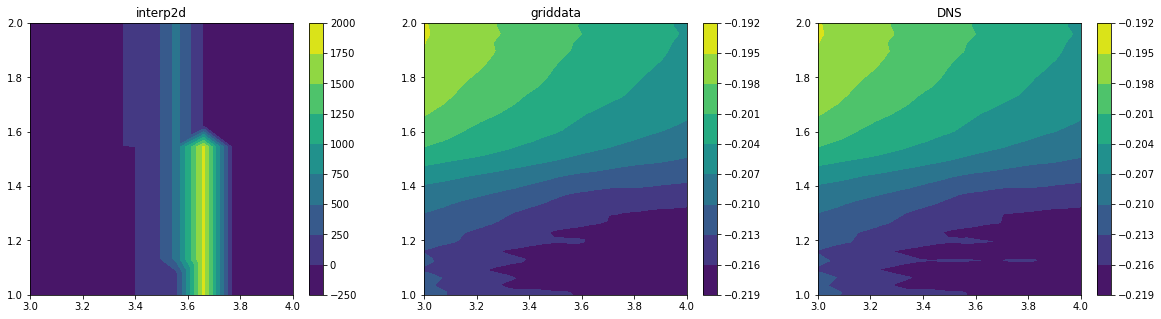

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
DNS_interp2d = ax[0].contourf(fine_grid_x, fine_grid_y, grid_z1)
DNS_griddata = ax[1].contourf(grid_x, grid_y, grid_z2)
DNS_box = ax[2].contourf(fine_grid_x, fine_grid_y, grid_z3)
fig.colorbar(DNS_interp2d, ax=ax[0])
fig.colorbar(DNS_griddata, ax=ax[1])
fig.colorbar(DNS_box, ax=ax[2])
# plt.title('interp2d')
ax[0].set_title('interp2d')
ax[1].set_title('griddata')
ax[2].set_title('DNS')